In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
# Perceptrons

import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

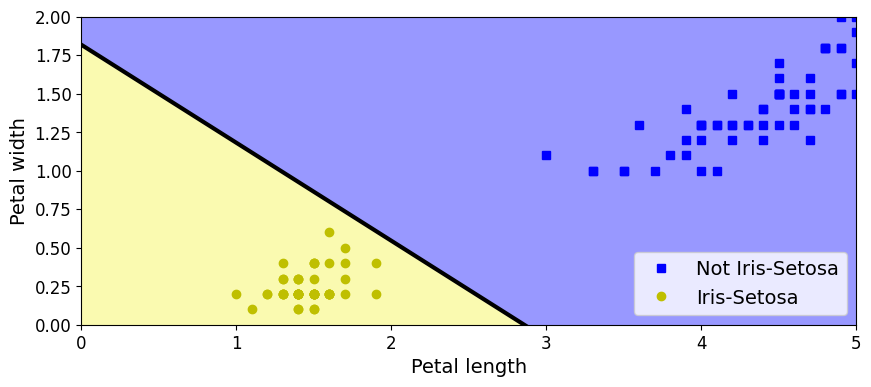

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

In [5]:
# Activation functions:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)


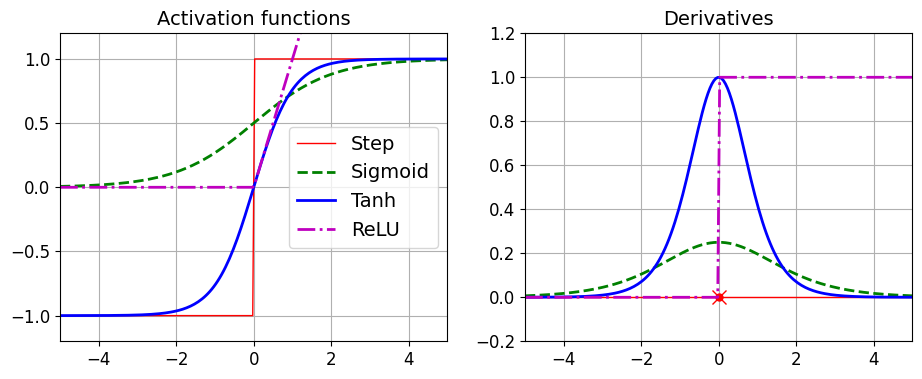

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

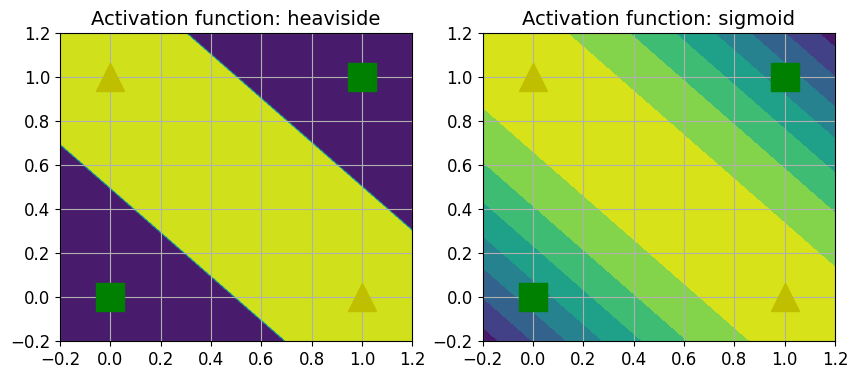

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

In [9]:
# Perceptron class is equivalent to Stochastic Gradient Descent with following hyper param:
# loss="percetron", learning_rate="constant", eta0=1 (learning rate), pentalty=None (no regularization)

# Perceptrons do not output a class probabilities, but make predictions based on a hard threshold (Logistic Regression better for this case)

# One preceptron is a linear classification model - downside - cannot solve trivial problems such as XOR logic
# However, some of the limitations can be eliminated by stacking multiple perceptrons together -> Multi-Layer Perceptrons (MLP)
# - can solve XOR problem

In [10]:
# Multi-Layer Perceptron (MLP) and Backpropagation (TLU - threshold logic unit)

# Backpropagation training algorithm:
# - basically a Gradient Descent using an efficient technique for computing the gradients automatically
# - in just two passes (forward and backward) - can compute the gradient of the network's error w.r.t. every single model parameter
# -> how each connection weight and bias term should be tweaked to reduce the error
# - then just performs a regular Gradient Descent step to tweak the weights
# -> repeat until convergence

# Many methods to compute gradients automatically - one used here colled reverse-mode autodiff
# - fast and precise - well suited when the function to differentiate has manny variables (e.g. connection weights) and a few outputs (one loss)
# - description on page 287,288

# It is importnat to initialize the hidden layers' weights randomly
# - if all of them are the same, e.g. all weights/biases=0, then back propagation will affect them all exactly the same, so they remain identical

# For backprogagation to work - new activation function
# - replaced step function with the logistic function - adds gradient for Gradient Descent
# - function needs to be continuous and differentiable
# - many options exist

In [11]:
# Regression MLPs
# - generally do not want to use an activation function for an output neuron - should be free to output any range of values
# - but can put some restrictions, e.g. if you want an output to only be positive - ReLU function
# - logistic function/hyperbolic tangent - can be used for predictions to fall into a given range by scaling to the appropriate range

# Loss is usually mean squared error
# - Mean absolute error can also be used, especially if you have a lot of outliers in the training set
# - Huber loss - combination of both

In [12]:
# Classification MLPs
# - for binary classification - just need one output neruon with logistic activation function - number between 0 - 1 (e.g. estimated probability of positive class)
# - multilabel binary classification tasks - more output neruons necessary - 1 per binary label for positive class
#   - output probabilities do not necessarily add up to 1 - allows the model to outout any combination of labels

# Multiclass classification
# in the case each instance belongs only to a single class, out of 3 or more - e.g. number classification (0 - 9)
# - need to have one output neuron peer class, with softmax activation function for the whole output layers 
#  -> ensures that all the estimated probabilities are between 0 and 1 and they add up to 1, required when the classes are exclussive

# When predicting probabilitiy distributions - cross-entropy is generally a good choice

In [13]:
# Keras
from tensorflow import keras
tf.__version__

'2.18.0'

In [14]:
keras.__version__

'3.7.0'

In [15]:
# Image Classifier using Sequential API - Fashion MNIST dataset - 10 fashion items\
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [16]:
X_train_full.shape

(60000, 28, 28)

In [17]:
X_train_full.dtype

dtype('uint8')

In [18]:
# Creatming validation set
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_test = X_test / 255.

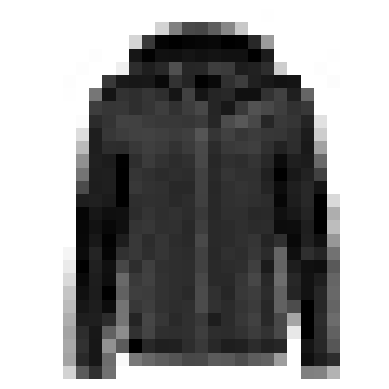

In [19]:
# Display one item:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [20]:
# The labels are the class IDs (represented as uint8), from 0 to 9:
y_train
# Let's give them names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

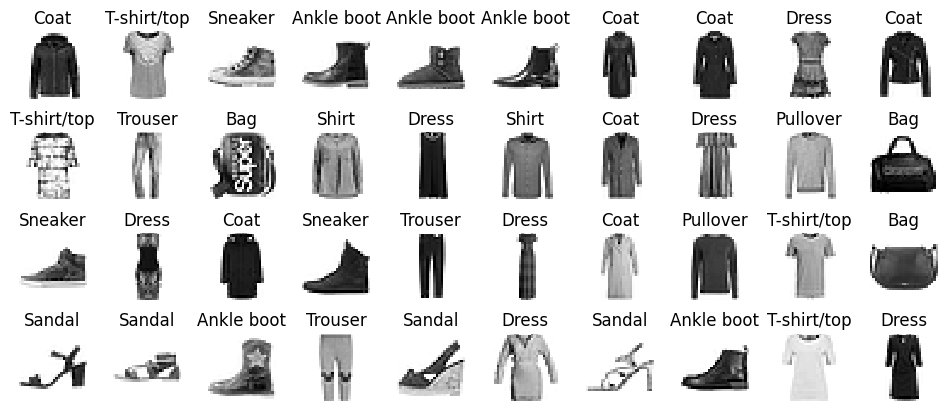

In [21]:
# Display samples from the dataset:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [22]:
# Creating the Model using Sequntial API
# simplest kind of Keras model - single stack of layers connected sequentially
model = keras.models.Sequential()
# converts each input image into 1D array - input X -> output X.reshape(-1,1)
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# add hidden layers with actiovation function, each Dense layer manages its own weight matrix and bias term
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
# output layer
model.add(keras.layers.Dense(10, activation="softmax"))

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Another way to pass a list of layers:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(10, activation="softmax")
])

model.layers

[<Flatten name=flatten_1, built=True>,
 <Dense name=dense_3, built=True>,
 <Dense name=dense_4, built=True>,
 <Dense name=dense_5, built=True>]

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

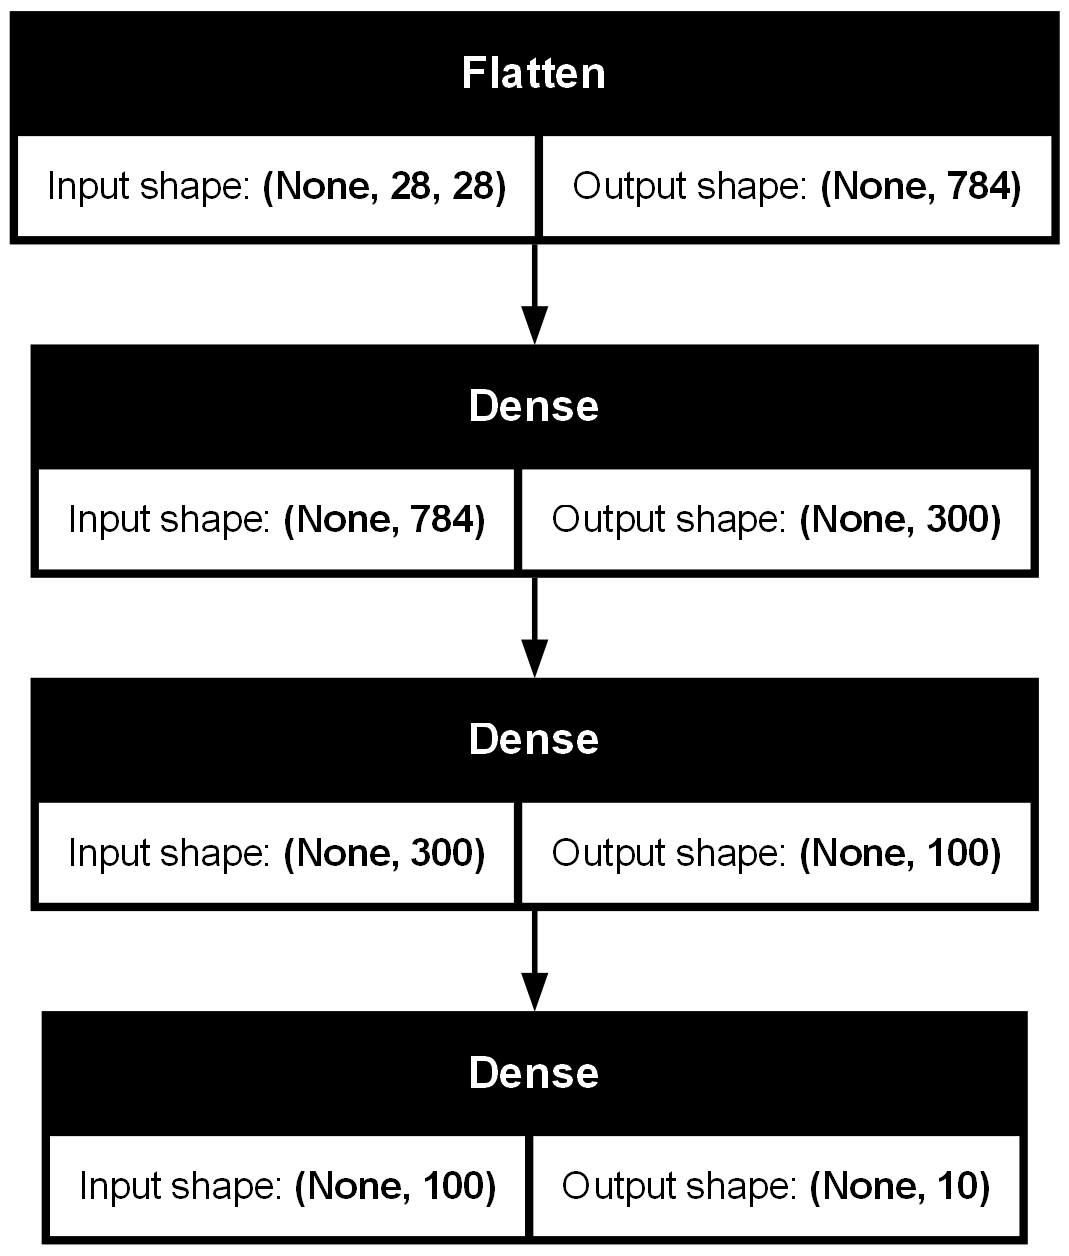

In [25]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [26]:
# Accessing the model's parameters such as layers and weights

In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [30]:
weights, biases = hidden1.get_weights()
weights
# Initialized with random weights to break symmetry, biases are just 0 at the start
# kernel_initializer can be used for a different initialization method

array([[ 0.05233094, -0.07068527,  0.04261191, ...,  0.03466222,
         0.04229888,  0.03793288],
       [ 0.06711206, -0.031333  ,  0.05099885, ..., -0.04482299,
         0.06155729,  0.0504405 ],
       [ 0.05232145, -0.04559249, -0.02501875, ..., -0.04742238,
         0.00365912,  0.0735691 ],
       ...,
       [ 0.07311828, -0.02430081, -0.0717148 , ..., -0.04752762,
        -0.0280339 , -0.01441617],
       [ 0.06418401, -0.07176198, -0.00959109, ...,  0.06426883,
         0.04927365,  0.03890408],
       [ 0.06627759,  0.06999794, -0.0676261 , ..., -0.00661537,
         0.07051761,  0.06863344]], dtype=float32)

In [29]:
print(weights.shape)
print(biases.shape)

(784, 300)
(300,)


In [35]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
# - sparce_cat... - sparse labels - each instance just a target class index - 0 to 9, exclusive
# -- e.g. for one target probability per class, 0,0,0,1,0,0,0,0,0,0 --> categorical_crossentropy
# ---> keras.utils.to_categorical() - convers sparse labels to one-hot vector labels
# - sgd - stochastic gradient descent
# - designing a classifier - want to measure its accuracy for training and evaluation

In [36]:
# Training and evaluation
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6898 - loss: 0.9959 - val_accuracy: 0.8330 - val_loss: 0.5062
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8286 - loss: 0.5013 - val_accuracy: 0.8516 - val_loss: 0.4352
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8424 - loss: 0.4505 - val_accuracy: 0.8530 - val_loss: 0.4169
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8518 - loss: 0.4188 - val_accuracy: 0.8594 - val_loss: 0.4164
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8621 - loss: 0.3924 - val_accuracy: 0.8716 - val_loss: 0.3784
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8657 - loss: 0.3781 - val_accuracy: 0.8684 - val_loss: 0.3818
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8690 - loss: 0.3674 - val_accuracy: 0.8666 - val_loss: 0.3798
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8706 - loss: 0.3592 - 

In [38]:
# History object contains training parameters, list of epoch and 
# dictionary (history.history) - has loss and extra metrics it measured at the end of each epoch
print(history.params)
print(history.epoch)
print(history.history.keys())

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


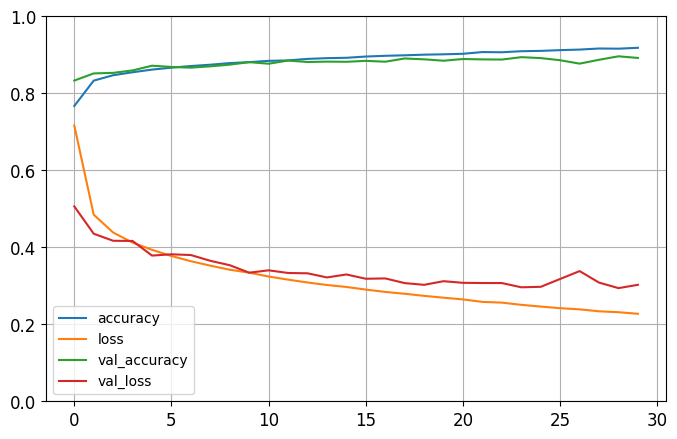

In [40]:
# With Pandas DataFrame you can call its plot() method to visualize the learning curves
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [41]:
# Evaluation
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8807 - loss: 0.3362


[0.3395521342754364, 0.8772000074386597]

In [42]:
# Making predictions
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.94, 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [43]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([9, 2, 1])

In [44]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

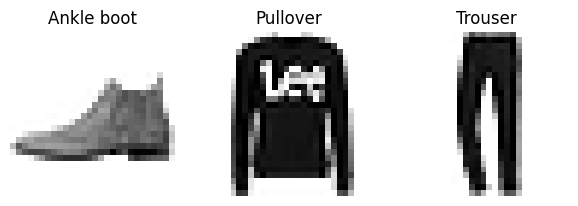

In [46]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()